## Importing Libraries

In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time, re, glob
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn.impute import SimpleImputer
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

In [2]:
files = glob.glob(os.path.join('datasets', '*.zip'))
data = pd.concat((pd.read_csv(file, compression='zip', header=1, low_memory=False) for file in files), ignore_index=True,)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518115 entries, 0 to 518114
Columns: 150 entries, id to settlement_term
dtypes: float64(112), object(38)
memory usage: 592.9+ MB


In [4]:
data.shape

(518115, 150)

Don't really need all these columns, will narrow them down.

In [5]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=150)

In [6]:
# Select columns to keep
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

data = data.loc[:,columnsToKeep]

In [7]:
data.shape

(518115, 37)

In [8]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,5000.0,36 months,13.90%,170.65,C,C1,NaN,OWN,...,3164.76,2552.03,2552.03,1835.24,716.79,0.0,0.0,0.0,Jun-2020,170.65
1,6500.0,6500.0,6475.0,36 months,8.81%,206.13,A,A5,10+ years,OWN,...,0.00,7015.28,6988.30,6500.00,515.28,0.0,0.0,0.0,Apr-2020,4754.21
2,24000.0,24000.0,24000.0,60 months,13.90%,557.20,C,C1,10+ years,MORTGAGE,...,20427.69,7206.53,7206.53,3572.31,3634.22,0.0,0.0,0.0,Jun-2020,557.20
3,18500.0,18500.0,18500.0,60 months,14.74%,437.60,C,C2,NaN,MORTGAGE,...,15121.23,6533.70,6533.70,3378.77,3154.93,0.0,0.0,0.0,Jul-2020,437.60
4,24000.0,24000.0,24000.0,60 months,20.00%,635.86,D,D2,8 years,MORTGAGE,...,20017.99,9484.57,9484.57,3982.01,5502.56,0.0,0.0,0.0,Jun-2020,635.86


In [9]:
# Transform features from string to numeric
for i in ["term","int_rate","emp_length","revol_util"]:
    data.loc[:,i] = \
        data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])

In [10]:
# Determine which features are numerical
numericalFeats = [x for x in data.columns if data[x].dtype != 'object']

In [11]:
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                       8
funded_amnt                     8
funded_amnt_inv                 8
term                            8
int_rate                        8
installment                     8
emp_length                  46259
annual_inc                      8
dti                          1153
delinq_2yrs                     8
mths_since_last_delinq     292561
mths_since_last_record     462994
open_acc                        8
pub_rec                         8
revol_bal                       8
revol_util                    682
total_acc                       8
out_prncp                       8
out_prncp_inv                   8
total_pymnt                     8
total_pymnt_inv                 8
total_rec_prncp                 8
total_rec_int                   8
total_rec_late_fee              8
recoveries                      8
collection_recovery_fee         8
last_pymnt_amnt                 8
dtype: int64

In [12]:
# Impute NaNs with mean 
fillWithMean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# Impute NaNs with zero
fillWithZero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

# Perform imputation
im = SimpleImputer(strategy='mean')   
data.loc[:,fillWithMean] = im.fit_transform(data[fillWithMean])

data.loc[:,fillWithZero] = data.loc[:,fillWithZero].fillna(value=0,axis=1)

In [13]:
# Check for NaNs one last time
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

In [14]:
# Feature engineering
data['installmentOverLoanAmnt'] = data.installment/data.loan_amnt
data['loanAmntOverIncome'] = data.loan_amnt/data.annual_inc
data['revol_balOverIncome'] = data.revol_bal/data.annual_inc
data['totalPymntOverIncome'] = data.total_pymnt/data.annual_inc
data['totalPymntInvOverIncome'] = data.total_pymnt_inv/data.annual_inc
data['totalRecPrncpOverIncome'] = data.total_rec_prncp/data.annual_inc
data['totalRecIncOverIncome'] = data.total_rec_int/data.annual_inc

newFeats = ['installmentOverLoanAmnt','loanAmntOverIncome', \
            'revol_balOverIncome','totalPymntOverIncome', \
           'totalPymntInvOverIncome','totalRecPrncpOverIncome', \
            'totalRecIncOverIncome']

In [15]:
np.any(np.isnan(data.loc[:,numericalFeats]))

False

In [16]:
np.any(np.isnan(data.loc[:,newFeats]))

True

In [17]:
data.loc[:,newFeats].max()

installmentOverLoanAmnt    0.042950
loanAmntOverIncome              inf
revol_balOverIncome             inf
totalPymntOverIncome            inf
totalPymntInvOverIncome         inf
totalRecPrncpOverIncome         inf
totalRecIncOverIncome           inf
dtype: float64

In [18]:
data.shape

(518115, 44)

In [19]:
with pd.option_context('mode.use_inf_as_na', True):
    # Dropping the rows with nan  
    # (or inf) values 
    data.dropna(inplace=True) 

In [20]:
np.any(np.isnan(data.loc[:,newFeats]))

False

In [21]:
data.shape

(516108, 44)

## Features for Training

In [22]:
# Select features for training
numericalPlusNewFeats = numericalFeats+newFeats
X_train = data.loc[:,numericalPlusNewFeats]

# Scale data
sX = pp.StandardScaler()
X_train.loc[:,:] = sX.fit_transform(X_train)

In [23]:
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'installmentOverLoanAmnt',
       'loanAmntOverIncome', 'revol_balOverIncome', 'totalPymntOverIncome',
       'totalPymntInvOverIncome', 'totalRecPrncpOverIncome',
       'totalRecIncOverIncome'],
      dtype='object')

In [24]:
# Designate labels for evaluation
labels = data.grade
labels.unique()

array(['C', 'A', 'D', 'B', 'E', 'G', 'F'], dtype=object)

In [25]:
# Fill missing labels
#labels = labels.fillna(value="Z")

# Convert labels to numerical values
lbl = pp.LabelEncoder()
lbl.fit(list(labels.values))
labels = pd.Series(data=lbl.transform(labels.values), name='grade')

# Store as y_train
y_train = labels

In [26]:
labelsOriginalVSNew = pd.concat([labels, data.grade],axis=1)
labelsOriginalVSNew

,grade,grade
0,2.0,C
1,0.0,A
2,2.0,C
3,2.0,C
4,3.0,D
5,3.0,D
6,2.0,C
7,2.0,C
8,0.0,A
9,1.0,B


In [27]:
# Compare loan grades with interest rates
interestAndGrade = pd.DataFrame(data=[data.int_rate,labels])
interestAndGrade = interestAndGrade.T

interestAndGrade.groupby("grade").mean()

,int_rate
grade,
0.0,1285.583177
1.0,1286.537482
2.0,1288.398079
3.0,1290.670952
4.0,1243.752083
5.0,1351.028571
6.0,1209.294118


### Goodness of the Clusters

In [29]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg( \
        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
        left_on="cluster",right_on="cluster")
    
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, \
        accuracyDF, overallAccuracy, accuracyByLabel

### K-means Application

In [31]:
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, \
                random_state=random_state)

kMeans_inertia = pd.DataFrame(data=[],index=range(10,31), \
                              columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[], \
    index=range(10,31),columns=['overallAccuracy'])

for n_clusters in range(10,31):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                    max_iter=max_iter, tol=tol, \
                    random_state=random_state)

    kmeans.fit(X_train)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train)
    X_train_kmeansClustered = pd.DataFrame(data= \
        X_train_kmeansClustered, index=X_train.index, \
        columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, \
    countMostFreq_kMeans, accuracyDF_kMeans, \
    overallAccuracy_kMeans, accuracyByLabel_kMeans = \
    analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = \
        overallAccuracy_kMeans

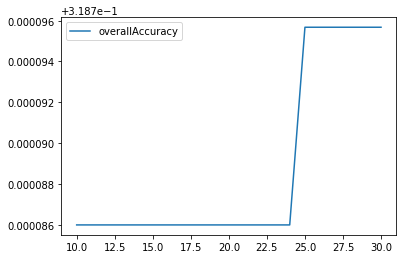

In [32]:
overallAccuracy_kMeansDF.plot()

In [33]:
accuracyByLabel_kMeans

0     0.319775
1     0.315501
2     0.317906
3     1.000000
4     0.326966
5     0.321928
6     0.314834
7     0.308585
8     0.322216
9     0.319213
10    0.317592
11    0.322443
12    0.324019
13    0.447917
14    0.322417
15    0.304948
16    0.318352
17    0.322707
18    0.353234
19    0.320889
20    0.317488
21    0.318611
22    0.319110
23    0.319296
24    0.328221
25    0.319451
26    0.319596
27    0.368421
28    0.314444
29    0.319905
dtype: float64

### Hierarchical Clustering Application

**WARNING:** The following cell takes over 4 hours to run

In [35]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = fastcluster.linkage_vector(X_train, method='ward', \
                               metric='euclidean')

Z_dataFrame = pd.DataFrame(data=Z,columns=['clusterOne', \
                'clusterTwo','distance','newClusterSize'])

In [36]:
Z_dataFrame[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,127418.0,359423.0,0.089558,2.0
1,421575.0,437440.0,0.089918,2.0
2,312566.0,342893.0,0.117577,2.0
3,399203.0,405009.0,0.127465,2.0
4,62306.0,77114.0,0.128125,2.0
5,103049.0,114328.0,0.128350,2.0
6,133841.0,240480.0,0.132277,2.0
7,155774.0,346188.0,0.133784,2.0
8,463869.0,465230.0,0.135074,2.0
9,459237.0,459503.0,0.136847,2.0


In [37]:
Z_dataFrame[518089:]

,clusterOne,clusterTwo,distance,newClusterSize


In [38]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 100
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = pd.DataFrame(data=clusters, \
    index=X_train.index,columns=['cluster'])

In [39]:
print("Number of distinct clusters: ", \
      len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  177


In [40]:
countByCluster_hierClust, countByLabel_hierClust, \
    countMostFreq_hierClust, accuracyDF_hierClust, \
    overallAccuracy_hierClust, accuracyByLabel_hierClust = \
    analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ", \
      overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.3190165624249188


In [41]:
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0      0.325363
1      0.321854
2      0.321429
3      0.356000
4      0.324022
5      0.303813
6      0.326265
7      0.309524
8      0.319329
9      0.305927
10     0.324050
11     0.303336
12     0.312478
13     0.328353
14     0.315097
15     0.307468
16     0.323877
17     0.309651
18     0.314785
19     0.308304
20     0.307509
21     0.309453
22     0.316549
23     0.319814
24     0.319737
25     0.315755
26     0.324919
27     0.325085
28     0.330711
29     0.325390
         ...   
147    0.321739
148    0.352262
149    0.500000
150    0.309751
151    0.316010
152    0.293772
153    0.319694
154    0.342756
155    0.308197
156    0.322423
157    0.500000
158    1.000000
159    0.328383
160    0.325714
161    0.323747
162    0.321853
163    0.295000
164    0.321264
165    0.324012
166    0.317771
167    0.323243
168    0.324183
169    0.359375
170    0.333333
171    0.297904
172    0.319023
173    0.318393
174    0.313839
175    0.312859
176    1.000000
Length: 177, dtype: floa

### HDBSCAN Application

In [44]:
import hdbscan

min_cluster_size = 20
min_samples = 20
alpha = 1.0
cluster_selection_method = 'leaf'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
    min_samples=min_samples, alpha=alpha, \
    cluster_selection_method=cluster_selection_method)

X_train_hdbscanClustered = hdb.fit_predict(X_train)
X_train_hdbscanClustered = pd.DataFrame(data= \
    X_train_hdbscanClustered, index=X_train.index, \
    columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan = \
    analyzeCluster(X_train_hdbscanClustered, y_train)

In [45]:
print("Overall accuracy from HDBSCAN: ", overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.3190146248459625


In [46]:
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,507314
1,42,1639
2,43,833
3,6,610
4,5,477
5,7,399
6,34,383
7,13,346
8,21,330
9,15,296


In [47]:
accuracyByLabel_hdbscan

0     0.318820
1     0.388889
2     0.371429
3     0.362832
4     0.351351
5     0.312500
6     0.312369
7     0.339344
8     0.300752
9     0.341463
10    0.375000
11    0.395349
12    0.400000
13    0.344828
14    0.317919
15    0.347826
16    0.293919
17    0.322581
18    0.350000
19    0.500000
20    0.321429
21    0.388889
22    0.321212
23    0.370370
24    0.416667
25    0.318841
26    0.463415
27    0.400000
28    0.400000
29    0.396825
        ...   
32    0.312925
33    0.343750
34    0.328571
35    0.308094
36    0.331034
37    0.404040
38    0.294118
39    0.385246
40    0.310345
41    0.368794
42    0.324910
43    0.308115
44    0.307323
45    0.361111
46    0.347826
47    0.349398
48    0.354167
49    0.422680
50    0.480000
51    0.428571
52    0.329268
53    0.523810
54    0.294118
55    0.346667
56    0.347826
57    0.320000
58    0.320000
59    0.393258
60    0.325000
61    0.400000
Length: 62, dtype: float64